<a href="https://colab.research.google.com/github/stwind/gan-experiments/blob/master/notebooks/stylegan2_ganspace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
#@title Install Dependencies
!pip install -Uq torchinfo ninja

     |████████████████████████████████| 112kB 10.8MB/s 


In [6]:
#@title Setup
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import io
import os
import re
import sys
import json
import math
import time
import random
import requests
import pickle
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import cv2
import IPython.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as tfms
import torchvision.models as models
import umap
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchinfo import summary
from fastprogress.fastprogress import progress_bar
from sklearn.decomposition import IncrementalPCA

## matplotlib style
sns.set('notebook', 'darkgrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 5),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 13,
})
plt.style.use("dark_background")

print("Runtime Infos:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("pytorch: {}".format(torch.__version__))
print("umap: {}".format(umap.__version__))
for i in range(torch.cuda.device_count()):
    print("cuda device #{}: {}".format(i, torch.cuda.get_device_name(i)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device type: {}".format(device.type))

from google.colab import drive
drive.mount('/content/gdrive')

!nvidia-smi

Runtime Infos:
numpy: 1.19.5
seaborn: 0.11.1
matplotlib: 3.2.2
pytorch: 1.8.0+cu101
umap: 0.5.1
cuda device #0: Tesla T4
current device type: cuda
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Thu Mar 18 12:36:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    30W /  70W |   1152MiB / 1510

In [3]:
#@title Utilities

def to_single_rgb(img):
    img = np.asarray(img)
    if len(img.shape) == 4: # take first frame from animations
        return img[0,:,:,:]
    if len(img.shape) == 2: # convert gray to rgb
        return img[:,:,np.newaxis].repeat(3, 2)
    if img.shape[-1] == 4: # drop alpha
        return img[:,:,:3]
    else:
        return img

def imread(url, size=None, mode=None):
    if url.startswith(('http:', 'https:')):
        f = io.BytesIO(requests.get(url).content)
    else:
        f = url
    img = PIL.Image.open(f)
    if size is not None:
        img.thumbnail((size, size), PIL.Image.ANTIALIAS)
    if mode is not None:
        img = img.convert(mode)
    return img

def pil2np(x):
    return np.asarray(x, np.float32) / 255.0

def imshow(img, fmt='png', retina=True, zoom=None):
    if isinstance(img, str):
        IPython.display.display(IPython.display.Image(filename=img, retina=retina))
        return
    
    if len(img.shape) == 1:
        n = len(img)
        side = int(np.sqrt(n))
        if (side * side) != n:
            raise ValueError('input is one-dimensional', img.shape)
        img = img.reshape(side, side)
    if len(img.shape) == 3 and img.shape[-1] == 1:
        img = img.squeeze()
    if img.dtype == np.float32:
        img = img * 255.0
    img = np.uint8(img.clip(0, 255))
    if fmt in ('jpeg', 'jpg'):
        img = to_single_rgb(img)

    data = io.BytesIO()
    PIL.Image.fromarray(img).save(data, fmt)
    height, width = img.shape[:2]
    if zoom is not None:
        width *= zoom
        height *= zoom
    IPython.display.display(IPython.display.Image(data=data.getvalue(),width=width,height=height, retina=retina))

def plt_imshow(img, figsize=(5,5), title=None, cmap=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()
    
def minmax(x, axis=None):
    mx = x.max(axis=axis, keepdims=True)
    mn = x.min(axis=axis, keepdims=True)
    return (x - mn) / (mx - mn)

def find_rectangle(n): 
    max_side = int(math.sqrt(n))
    for h in range(2, max_side+1)[::-1]:
        w = n // h
        if (h * w) == n:
            return (h, w)
    return (n, 1)

def make_mosaic(imgs, nx=None, ny=None, gap=3):
    n, h, w = imgs.shape[:3]
    has_channels = len(imgs.shape) > 3
        
    if nx is None and ny is None:
        ny,nx = find_rectangle(n)
    elif ny is None:
        ny = math.ceil(n / nx)
    elif nx is None:
        nx = math.ceil(n / ny)

    sh, sw = h + gap, w + gap
    shape = (ny * sh - gap, nx * sw - gap)
    if has_channels:
        shape += (3,)

    canvas = np.zeros(shape, dtype=imgs.dtype)
    for i, x in enumerate(imgs):
        iy, ix = divmod(i, nx)
        canvas[iy * sh:iy * sh + h, ix * sw:ix * sw + w] = x
    return canvas

def resize_images(from_dir, to_dir, size):
    os.makedirs(to_dir, exist_ok=True)
    for p in progress_bar(os.listdir(from_dir)):
        im = imread(os.path.join(from_dir, p)).resize((size, size))
        im.save(os.path.join(to_dir, p))


def lerp(a, b, t):
    return a * (1.0 - t) + b * t


def slerp(a, b, t):
    omega = torch.arccos(torch.dot(a / a.norm(), b / b.norm()))
    so = torch.sin(omega)
    return (((1.0 - t) * omega).sin() * a + (t * omega).sin() * b) / so


def make_analogy_grid(anchors):
    n, dim = len(anchors), anchors.shape[1]
    rows = n // 2 + 1
    cols = n - rows + 1
    grid = np.zeros((rows, cols, dim), dtype=np.float32)
    for y in range(rows):
        for x in range(cols):
            if x == 0 or y == 0:
                if x == 0 and y == 0:
                    idx = 0
                elif x == 0:
                    idx = y * 2 - 1
                else:
                    idx = x * 2
                grid[y, x] = anchors[idx]
            else:
                anal_vec = grid[y, x - 1] + grid[y - 1, x] - grid[y - 1, x - 1]
                anal_unit_vec = np.nan_to_num(anal_vec / np.linalg.norm(anal_vec))
                avg_len = (
                    np.linalg.norm(grid[y, x - 1])
                    + np.linalg.norm(grid[y - 1, x])
                    + np.linalg.norm(grid[y - 1, x - 1])
                ) / 3.0
                grid[y, x] = avg_len * anal_unit_vec
    return grid.reshape(-1, dim)


def make_mine_grid(anchors, nrow, space, interpolate=slerp):
    dims = anchors.shape[1:]
    ncol = len(anchors) // nrow
    rows = (nrow - 1) * space + 1
    cols = (ncol - 1) * space + 1

    grid = anchors.new_zeros((rows, cols) + dims)

    for y in range(rows):
        for x in range(cols):
            if y % space == 0 and x % space == 0:
                idx = (y // space) * ncol + (x // space)
                grid[y, x, :] = anchors[idx]

    for y in range(rows):
        for x in range(cols):
            if y % space == 0 and x % space != 0:
                prev = space * (x // space)
                cur = prev + space
                t = (x - prev) / space
                grid[y, x] = interpolate(grid[y, prev], grid[y, cur], t)

    for y in range(rows):
        for x in range(cols):
            if y % space != 0:
                prev = space * (y // space)
                cur = prev + space
                t = (y - prev) / space
                grid[y, x] = interpolate(grid[prev, x], grid[cur, x], t)

    return grid.view(-1, *dims)


def denormalize(img):
    return (img * 0.5 + 0.5).clamp(0, 1)

In [4]:
!if cd stylegan2-ada-pytorch; then git pull; else git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git; fi

if "/content/stylegan2-ada-pytorch" not in sys.path:
    sys.path.append('/content/stylegan2-ada-pytorch')

/bin/bash: line 0: cd: stylegan2-ada-pytorch: No such file or directory
Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 120
Receiving objects: 100% (125/125), 1.12 MiB | 22.10 MiB/s, done.
Resolving deltas: 100% (53/53), done.


## Model

In [161]:
with open("/content/gdrive/My Drive/ukiyoe/ukiyoe-network-snapshot-000300.pkl", 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)

In [209]:
n_samples = 80000
batch_size = 80
n_batch = math.ceil(n_samples / batch_size)

pca = IncrementalPCA(n_components=80, batch_size=batch_size)

for b in progress_bar(range(n_batch)):
    z = torch.randn((batch_size, G.z_dim)).to(device)
    w = G.mapping(z, None).cpu().flatten(start_dim=1).numpy()

    pca.partial_fit(w)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_incremental_pca.py:309: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


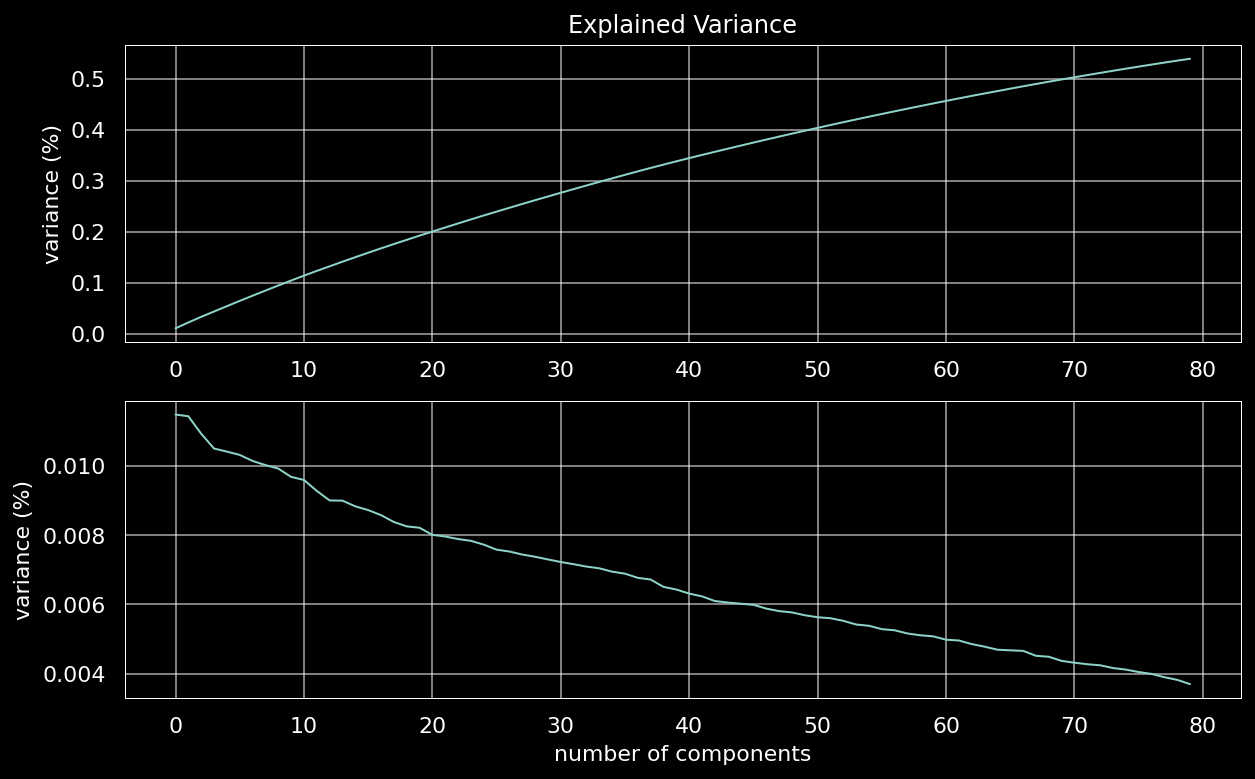

In [210]:
fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(np.cumsum(pca.explained_variance_ratio_))
ax1.set(ylabel='variance (%)', title='Explained Variance')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(pca.explained_variance_ratio_)
ax2.set(xlabel='number of components',ylabel='variance (%)')

plt.show()

In [211]:
comps = pca.components_.reshape(-1,G.num_ws, G.w_dim).astype(np.float32)
comps = torch.from_numpy(comps).to(device)

stdev = np.sqrt(pca.explained_variance_)

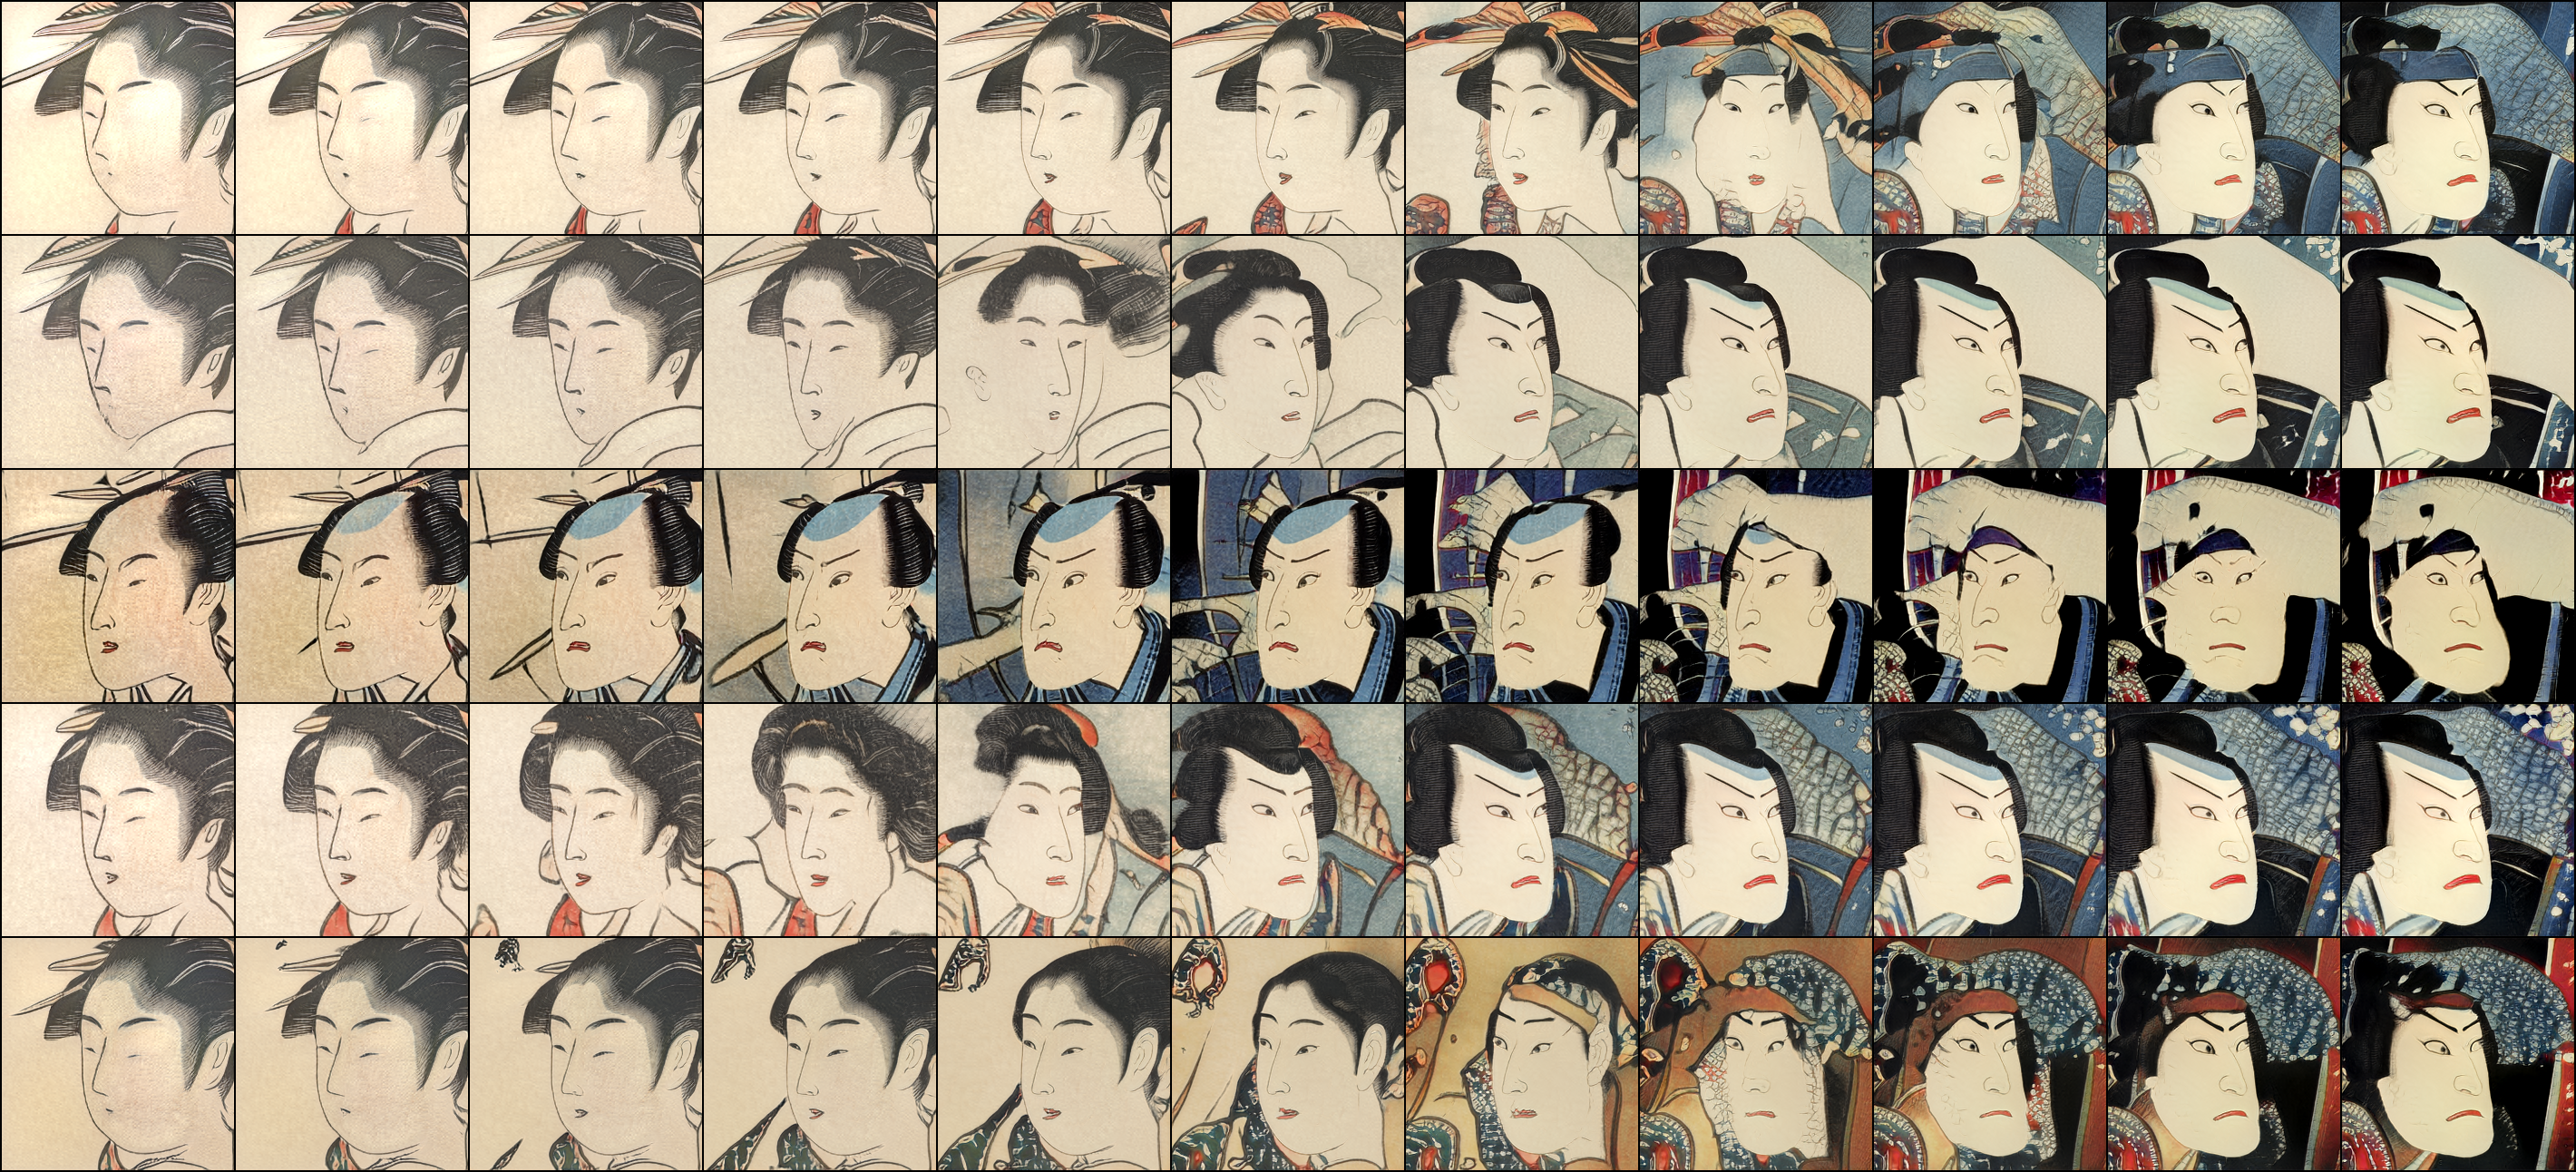

In [221]:
comp_idx = 0

t = torch.linspace(-5, 6, 11).view(-1,1,1).expand(11,G.num_ws,G.w_dim).to(device)

images = []
for _ in range(5):
    z = torch.randn((1, G.z_dim)).to(device)
    w = G.mapping(z, None, truncation_psi=0.7)

    w1 = w.expand(11,-1,-1) + comps[comp_idx] * stdev[comp_idx] * t

    imgs = G.synthesis(w1).cpu()
    images.append(imgs)

images = torch.cat(images)

imshow(make_grid(denormalize(images),nrow=11).permute(1,2,0).numpy())